In [1]:
import numpy as np 
import pandas as pd 
import joblib
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import tqdm

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10,15
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [2]:
# df = pd.read_csv("C:/Diplom/the_proj.csv")
# вместо этого генерируем датасет

# EDA, датасет полность синтезирован, код из основной части проекта

### Ecome_toy_dataset

In [3]:
ecomdata = pd.DataFrame()

In [4]:
Заказ_но = [i for i in range(1, 10000001)] #генерим заказы они у нас уникальны в отличие от других признаков
ecomdata['Заказ_но'] = Заказ_но

In [5]:
ecomdata['Пол'] = np.random.choice(list('МЖ'), len(ecomdata))#генерим пол

In [6]:
Возвраст = np.random.normal(40, 6, 10000000).round(0)# генерим возраст
ecomdata['Возвраст'] = Возвраст

In [7]:
Клиент_но = np.random.randint(2, 4000, 10000000).round(0)# генерим клиентов
ecomdata['Клиент_но'] = Клиент_но

In [8]:
Товар_но = np.random.randint(2, 100, 10000000).round(0)# генерим товар
ecomdata['Товар_но'] = Товар_но

In [9]:
Регион_но = np.random.randint(2, 20, 10000000).round(0)# генерим регион
ecomdata['Регион_но'] = Регион_но

In [10]:
Группа_но = np.random.randint(2, 100, 10000000).round(0)# генерим группу товаров
ecomdata['Группа_но'] = Группа_но

In [11]:
Оборот = np.random.randint(500, 50000, 10000000).round(0)# генерим Оборот
ecomdata['Оборот'] = Оборот

In [12]:
Количество = np.random.randint(1, 10, 10000000).round(0)# генерим количество
ecomdata['Количество'] = Количество

In [13]:
ecomdata.groupby('Клиент_но').count()
ecomdata.head(3)

,Заказ_но,Пол,Возвраст,Клиент_но,Товар_но,Регион_но,Группа_но,Оборот,Количество
0,1,Ж,35.0,3769,49,5,16,7275,9
1,2,Ж,35.0,1350,10,5,57,35750,6
2,3,М,41.0,484,22,18,20,49169,7


In [14]:
df = ecomdata

In [15]:
#смотрим на данные
def param_data(data): 
    param = pd.DataFrame({
              'dtypes': data.dtypes.values,
              'nunique': data.nunique().values,
              'isna': data.isna().sum().values,
              'loc[0]': data.loc[0].values,
              }, 
             index = data.loc[0].index)
    return param

param_data(df)

,dtypes,nunique,isna,loc[0]
Заказ_но,int64,10000000,0,1
Пол,object,2,0,Ж
Возвраст,float64,64,0,35
Клиент_но,int32,3998,0,3769
Товар_но,int32,98,0,49
Регион_но,int32,18,0,5
Группа_но,int32,98,0,16
Оборот,int32,49500,0,7275
Количество,int32,9,0,9


По пропускам все хорошо, но много данных с типом object, Машина не понимает такие данные, их мы обработаем позже.

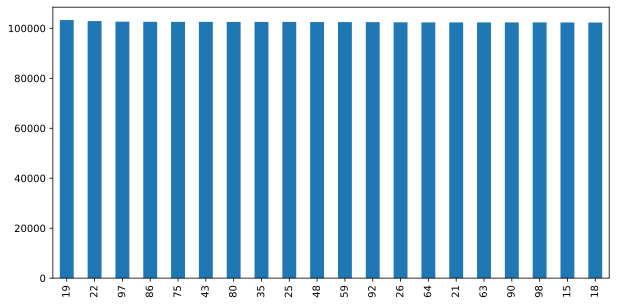

In [16]:
ds = df['Группа_но'].value_counts()
ds.columns = ['Группа_но', 'Оборот']
ds.head(20).plot(kind = 'bar', figsize=(10,5)) #топ 20

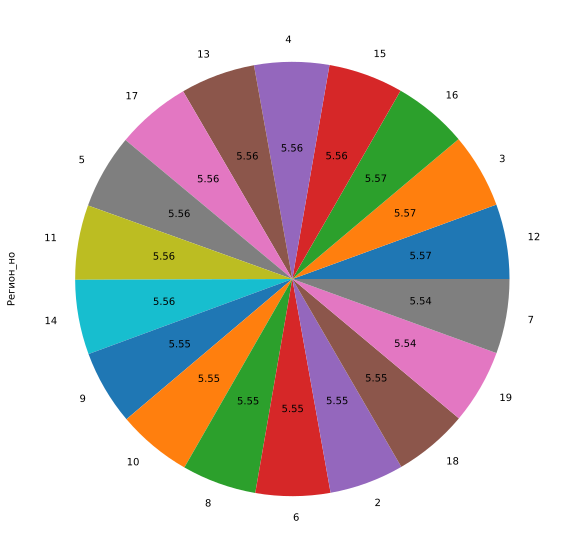

In [17]:
# топ 20 городов где больше всего покупают
ds_pie = df['Регион_но'].value_counts()
ds_pie.columns = ['Регион_но', 'Оборот']
ds_pie.head(20).plot(kind = 'pie', autopct='%.2f', fontsize=10, figsize=(10,10)) #топ 20

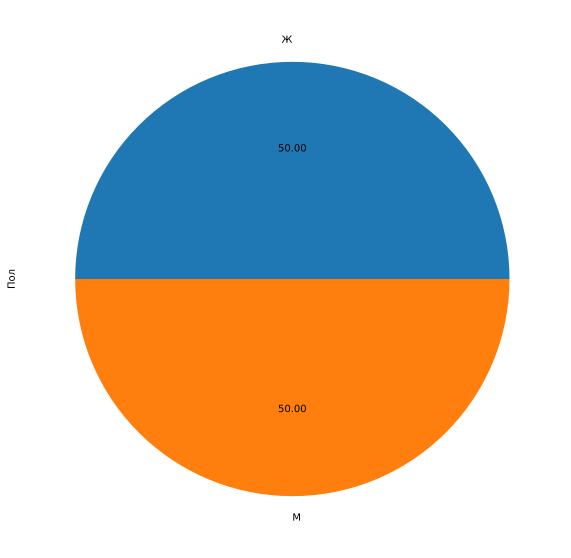

In [18]:
# кто больше покупает
ds_pie = df['Пол'].value_counts()
ds_pie.columns = ['Пол', 'Оборот']
ds_pie.head(20).plot(kind = 'pie', autopct='%.2f', fontsize=10, figsize=(10,10)) #МЖ

In [19]:
#группируем по товарной группе, допгрупировка по 0 уровню, сбрасываем индекс
ds_tgb = df.groupby(['Группа_но']).sum() \
  .groupby(level=0).cumsum().reset_index()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000225FF117648>,
      dtype=object)

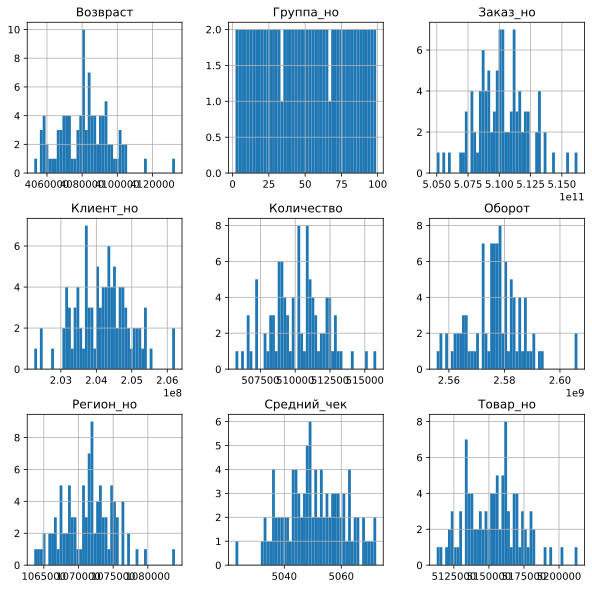

<Figure size 432x288 with 0 Axes>

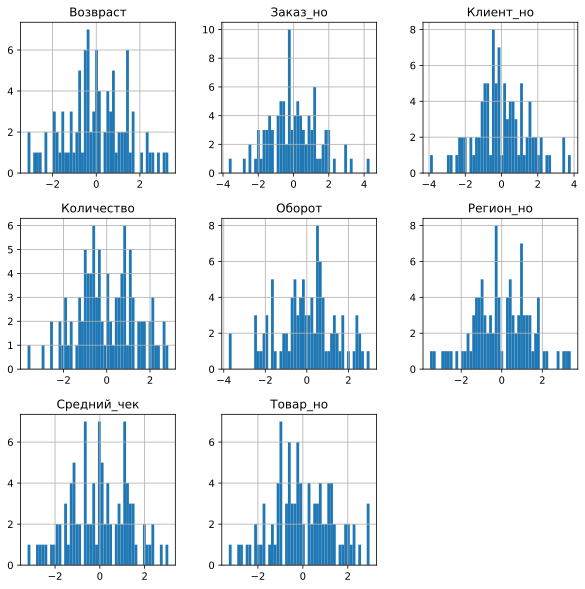

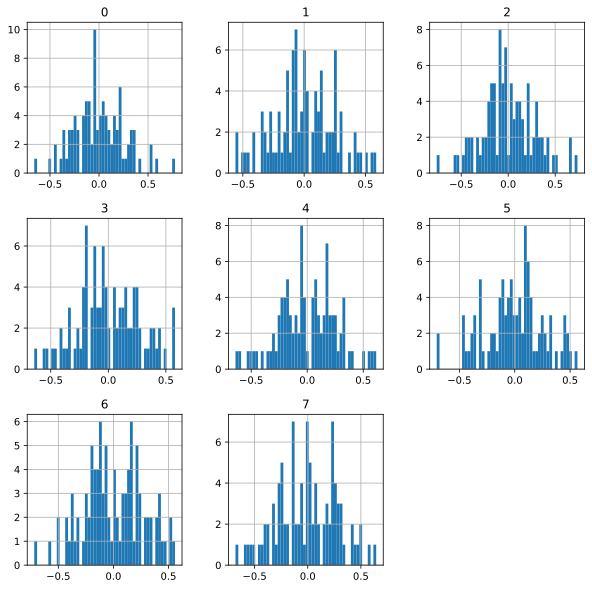

In [20]:
#Добавляем новую фичу средний чек
ds_tgb['Средний_чек'] = ds_tgb['Оборот'] / ds_tgb['Количество']
ds_tgb.hist(bins=50, figsize=(10,10))
#Нормализцем и смотри на распределение
plt.figure()
ds_tgb_diff = ds_tgb.drop('Группа_но', axis = 1)
normalized_df=(ds_tgb_diff-ds_tgb_diff.mean())/ds_tgb_diff.std()
normalized_df.diff().hist(bins=50, figsize=(10,10))
#Второй способ
from sklearn import preprocessing
x = ds_tgb_diff.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_df_2 = pd.DataFrame(x_scaled)
normalized_df_2.diff().hist(bins=50, figsize=(10,10))

в библиотеке sklearn метод лучше чем ручной т.к. лучше нормализует данные, делал больше для сравнение двух метдов. В целом видим что основная масса заказов с чеком до 2000р рублей. Есть выбросы в среднем чеке. но их убирать не будем т.к. наша цель рекомендация товара а не прогноз цены

In [21]:
#Посортируем и посмотрим в какой ТГ самый большой средний чек
ds_tgb_mean = ds_tgb.sort_values(['Средний_чек']).reset_index()
ds_tgb_mean = ds_tgb_mean.drop(['index', 'Количество', 'Оборот'], axis=1)

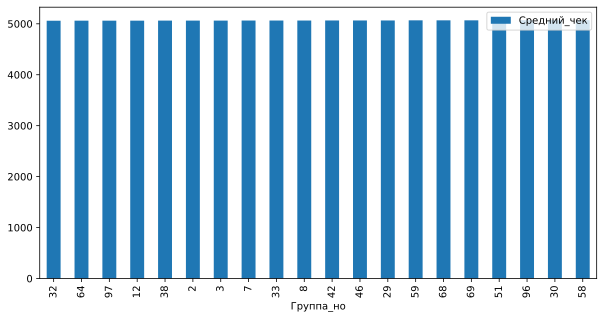

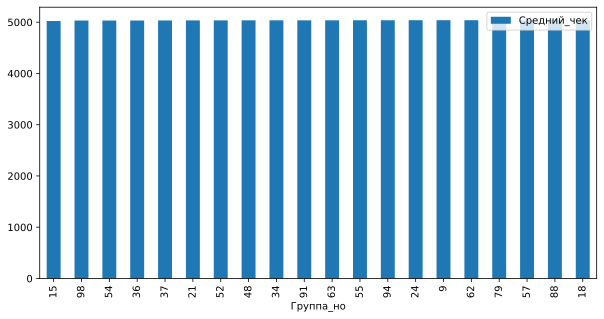

In [22]:
#Посмотрим на топ 20 самых больших и маленьких чеков
ds_tgb_mean.tail(20).plot(kind = 'bar', x='Группа_но', y='Средний_чек', figsize=(10,5)) #можно сортирнуть от максимальных значений к минимальным но это более затратно
ds_tgb_mean.head(20).plot(kind = 'bar', x='Группа_но', y='Средний_чек', figsize=(10,5))

In [23]:
#Посмотрим какой товар часто покупают
temp = df[['Клиент_но', 'Товар_но', 'Заказ_но']].groupby(['Клиент_но', 'Товар_но',]).count()
temp.sort_values("Заказ_но", ascending=False, inplace=True)
temp.reset_index(drop=False, inplace=True)
temp.rename(columns={'Товар_но': 'Популярный_продукт',}, inplace=True)
temp.drop_duplicates(subset= ['Клиент_но'], keep = "first", inplace=True)
temp.head(20)

,Клиент_но,Популярный_продукт,Заказ_но
0,458,30,53
1,1426,12,53
2,3365,92,52
3,733,8,52
4,3860,24,50
5,298,10,49
6,3654,55,49
7,3432,58,49
8,274,50,49
9,51,78,48


In [24]:
#Оставил для истории
# посмотрим на долю доставки в общем количестви транзакция для того чтобы принять решенеи о дропе
#dj = len(df[df.Бренд == "Услуги"])/len(df.Документ_Но)*100
#round(dj, 2)
#7% крепко но все же дропаем, т.к. иначе мы будем предлагать клиентам, не товар а доставку. 
#Доставка является доп.услугой которую клиент возьмет в любом случае если она ему нужна. 
#Нет возможности купить товар в компании а доставку заказать в другом месте
#удаление доставки
#df = df[~df.Наименование_Товара.str.contains("Доставка")]

In [25]:
# добавляем средний чек
df['Средний_чек'] = df['Оборот'] / df['Количество']

#В исходном датафрейме было много столбцом с типом object, перевеодим в цифру
#Был вариант что на старте закодирую

In [26]:
#Выбираем столбцы с типом object
#objFeatures = df.select_dtypes(include="object").columns

#Делаем цикл чтобы закодировать данные с типом object
#le = preprocessing.LabelEncoder()
#
#for feat in objFeatures:
#    df[feat] = le.fit_transform(df[feat].astype(str))


#Кодирование пола для модели
df['Пол']=df['Пол'].map({'Ж':2, 'М':1}).astype('int8')    

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Заказ_но     int64  
 1   Пол          int8   
 2   Возвраст     float64
 3   Клиент_но    int32  
 4   Товар_но     int32  
 5   Регион_но    int32  
 6   Группа_но    int32  
 7   Оборот       int32  
 8   Количество   int32  
 9   Средний_чек  float64
dtypes: float64(2), int32(6), int64(1), int8(1)
memory usage: 467.3 MB


In [27]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Заказ_но,Пол,Возвраст,Клиент_но,Товар_но,Регион_но,Группа_но,Оборот,Количество,Средний_чек
Заказ_но,1.000000,-0.000493,0.000444,0.000090,-0.000073,0.000807,-0.000149,-0.000119,-0.000158,0.000173
Пол,-0.000493,1.000000,0.000356,0.000154,0.000352,-0.000185,-0.000050,0.000520,0.000204,0.000156
Возвраст,0.000444,0.000356,1.000000,-0.000132,0.000235,-0.000452,-0.000322,-0.000555,0.000206,-0.000497
Клиент_но,0.000090,0.000154,-0.000132,1.000000,-0.000025,0.000201,-0.000055,-0.000159,-0.000244,-0.000111
Товар_но,-0.000073,0.000352,0.000235,-0.000025,1.000000,-0.000192,0.000343,0.000031,0.000136,0.000139
Регион_но,0.000807,-0.000185,-0.000452,0.000201,-0.000192,1.000000,-0.000110,0.000040,-0.000280,0.000475
Группа_но,-0.000149,-0.000050,-0.000322,-0.000055,0.000343,-0.000110,1.000000,-0.000415,-0.000191,0.000103
Оборот,-0.000119,0.000520,-0.000555,-0.000159,0.000031,0.000040,-0.000415,1.000000,0.000057,0.498888
Количество,-0.000158,0.000204,0.000206,-0.000244,0.000136,-0.000280,-0.000191,0.000057,1.000000,-0.621133
Средний_чек,0.000173,0.000156,-0.000497,-0.000111,0.000139,0.000475,0.000103,0.498888,-0.621133,1.000000


#### комент к основной работе
///Видим большую корреляцию между Рег_Офис и РО_Отдел, Средний_чек и Оборот, удаляем Рег_Офис и Средний_чек. Под вопросом Merdis_ПодГруппа и Merdis_Группа.///

In [28]:
df = df.drop(['Средний_чек'], axis = 1)

# Модель №1 
### прогнозирование на основе классивикатора LGBM

Разделение данных на у и Х

In [29]:
X = df

In [30]:
#X.sort_values("Дата_Создания", inplace=True)
#X.reset_index(drop=True, inplace=True)

In [31]:
#Список последних транзакций для каждого клиента
y_last = X.drop_duplicates(subset=['Клиент_но'], keep='last').Заказ_но.unique().tolist()

In [32]:
#добавляем в df одновременно с таргетом
df = X.loc[X['Заказ_но'].isin(y_last)]

In [33]:
#заменяем X на новый уже без последней транзакции
#Х датафрейм, из которого мы будем извлекать фичи для df.
X = X.loc[~X['Заказ_но'].isin(y_last)]
#удаляем лишние колонки
#X.drop(['Дата_Создания',], axis=1, inplace=True)

In [34]:
#Добавим самый часто покупаемый продукт
df = pd.merge(df, temp[['Клиент_но', 'Популярный_продукт']], how='left', left_on='Клиент_но', right_on='Клиент_но', left_index=True)
df['Популярный_продукт'] = df['Популярный_продукт'].astype(str)
df.shape

(3998, 10)

In [35]:
#закодируем популярные товары для классификатора
prod_enc = LabelEncoder()
df['Популярный_продукт'] = prod_enc.fit_transform(df.Популярный_продукт)

In [36]:
#список уникальных клиентов
unique_client = df.Клиент_но.unique().tolist()

client_train, client_hold = train_test_split(unique_client, test_size=0.03, random_state=42, 
                                             shuffle=True)
client_train, client_valid = train_test_split(client_train, test_size=0.3, random_state=42, 
                                              shuffle=True)

In [37]:
df_hold = df.loc[df['Клиент_но'].isin(client_hold)]
df_hold.reset_index(drop=True, inplace=True)

In [38]:
#Оставляем только самые популярные товары для упрощенного классификатора
top_product = list(df.Товар_но[df.Товар_но.value_counts(ascending=False)])

In [39]:
#Решаем, сколько таргетов оставить для модели классификации
#В трейне и валидации будет сокращенное число у
df = df.loc[df['Товар_но'].isin(top_product[0:250])] 
df['Товар_но'].nunique()

24

In [40]:
#Уже сокращенную выборку делим на тренировчную и валидационную
df_train = df.loc[df['Клиент_но'].isin(client_train)] 
df_train.reset_index(drop=True, inplace=True)
df_valid = df.loc[df['Клиент_но'].isin(client_valid)] 
df_valid.reset_index(drop=True, inplace=True)

In [41]:
#Если в валидационной выборке будут продукты, не встреченные раньше, то тренировка прервется
lost = list(set(df_valid['Товар_но']) - set(df_train['Товар_но']))
print(lost)

[]


In [42]:
# удаляем lost, если есть
df_valid = df_valid.loc[~df_valid['Товар_но'].isin(lost)]

In [43]:
#Подразумевается, что мы не будем пытаться предскзывать новые товары
le = LabelEncoder()
#Кодировать только после удаления всего лишнего
y_train = le.fit_transform(df_train['Товар_но'])
y_valid = le.transform(df_valid['Товар_но'])
#le.inverse_transform(y_pred)

In [44]:
#Сохраняем метки
joblib.dump(le, 'le.pkl') 
#загрузка
#le = joblib.load('le.pkl')

['le.pkl']

In [45]:
#Список фич для модели
feature = ['Заказ_но', 'Пол','Возвраст', 'Клиент_но', 'Товар_но','Регион_но', 'Группа_но', 'Количество', 'Популярный_продукт']
cat_features = ['Заказ_но', 'Пол','Возвраст', 'Клиент_но', 'Товар_но','Регион_но', 'Группа_но', 'Количество', 'Популярный_продукт']

In [46]:
y_hold = df_hold.groupby("Клиент_но")['Товар_но'].agg(lambda x: x.tolist())
y_hold = pd.DataFrame(y_hold)
y_hold.columns = ['product_ids']
y_hold.reset_index(drop=False, inplace=True)

In [47]:
hold = df_hold[['Заказ_но', 'Пол','Возвраст', 'Клиент_но', 'Товар_но','Регион_но', 'Группа_но', 'Количество', 'Популярный_продукт']].groupby(['Клиент_но']).first()

In [48]:
# заново используем df_hold для результата
df_hold = pd.merge(y_hold, hold, how='left', left_on='Клиент_но', right_on='Клиент_но', left_index=True)
df_hold.reset_index(drop=True, inplace=True)
df_hold.head(3)

,Клиент_но,product_ids,Заказ_но,Пол,Возвраст,Товар_но,Регион_но,Группа_но,Количество,Популярный_продукт
0,130,[66],9998336,1,27.0,66,6,72,1,49
1,134,[37],9998984,1,29.0,37,3,72,3,26
2,232,[16],9996950,1,39.0,16,9,22,2,56


In [49]:
del y_hold, hold, temp

In [50]:
#При проверке пропуски будут проблемой. Заполняем их, или удаляем строки
df_hold.dropna(inplace=True)
df_hold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Клиент_но           120 non-null    int64  
 1   product_ids         120 non-null    object 
 2   Заказ_но            120 non-null    int64  
 3   Пол                 120 non-null    int8   
 4   Возвраст            120 non-null    float64
 5   Товар_но            120 non-null    int32  
 6   Регион_но           120 non-null    int32  
 7   Группа_но           120 non-null    int32  
 8   Количество          120 non-null    int32  
 9   Популярный_продукт  120 non-null    int32  
dtypes: float64(1), int32(5), int64(2), int8(1), object(1)
memory usage: 7.1+ KB


In [51]:
classifier = LGBMClassifier(objective = 'multiclass', num_leaves=4, n_estimators=100, random_state=42,
                           subsample_freq=1, subsample=0.75, colsample_bytree=0.9, learning_rate=0.05)

In [52]:
%%time
classifier.fit(df_train[feature], df_train['Товар_но'], eval_set=[(df_valid[feature], df_valid['Товар_но'])], 
                early_stopping_rounds=5, verbose=10, categorical_feature = cat_features)

Training until validation scores don't improve for 5 rounds
[10]	valid_0's multi_logloss: 1.9042
[20]	valid_0's multi_logloss: 1.13067
[30]	valid_0's multi_logloss: 0.702597
[40]	valid_0's multi_logloss: 0.442992
[50]	valid_0's multi_logloss: 0.277457


C:\Users\potopnins\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\potopnins\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Возвраст', 'Группа_но', 'Заказ_но', 'Клиент_но', 'Количество', 'Пол', 'Популярный_продукт', 'Регион_но', 'Товар_но']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\potopnins\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\potopnins\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is 

[60]	valid_0's multi_logloss: 0.181262
[70]	valid_0's multi_logloss: 0.117485
[80]	valid_0's multi_logloss: 0.0796227
[90]	valid_0's multi_logloss: 0.0532258
[100]	valid_0's multi_logloss: 0.0363385
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0363385
Wall time: 512 ms


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=4,
               objective='multiclass', random_state=42, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=0.75,
               subsample_for_bin=200000, subsample_freq=1)

In [53]:
#Сохранение модели
joblib.dump(classifier, 'classifier.pkl') 
#загрузка
#classifier = joblib.load('classifier.pkl')

['classifier.pkl']

In [54]:
classifier.predict(df_train[feature].head(1))

array([10])

In [55]:
#На сайте запросы поступают по одному
y_pred = classifier.predict_proba(df_train[feature].head(1))
#минус перед y, чтобы сортировка шла по убыванию и можно было n вместо 30 брать
best_n = np.argsort(-y_pred, axis=1)[:,0:20]
best_n

array([[ 2, 16, 14, 12, 21,  1, 10, 20, 23,  6, 18, 13,  3, 17, 22, 19,
         4,  5, 11, 15]], dtype=int64)

In [56]:
recommended = list(le.inverse_transform(best_n[0]))
print(recommended)

[10, 74, 66, 55, 94, 9, 41, 92, 99, 22, 85, 59, 12, 77, 97, 88, 14, 20, 43, 73]


In [57]:
def average_precision(actual, recommended, k=20):
    ap_sum = 0
    hits = 0
    for i in range(k):
        product_id = recommended[i] if i < len(recommended) else None
        if product_id is not None and product_id in actual:
            hits += 1
            ap_sum += hits / (i + 1)
    return ap_sum / k


def normalized_average_precision(actual, recommended, k=20):
    actual = set(actual)
    if len(actual) == 0:
        return 0.0
    
    ap = average_precision(actual, recommended, k=k)
    ap_ideal = average_precision(actual, list(actual)[:k], k=k)
    return ap / ap_ideal

In [58]:
%%time
client_list = list(df_hold.Клиент_но.unique())
ap_values = []

for Клиент_но in tqdm.tqdm(client_list):
    df = df_hold[df_hold.Клиент_но ==Клиент_но]
    y_pred = classifier.predict_proba(df[feature])#, num_iteration=classifier.best_iteration_
    #n = int(df['product_len'].clip(1, 30))
    n = 30
    recommended = list(le.inverse_transform(np.argsort(-y_pred, axis=1)[:,0:n][0]))
    #ap = average_precision(df['product_ids'].tolist()[0], recommended)
    ap = normalized_average_precision(df['product_ids'].tolist()[0], recommended)
    #print(ap)
    ap_values.append(ap)
map_score = sum(ap_values) / len(ap_values)
print(map_score)

100%|███████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 175.69it/s]

0.26666666666666666
Wall time: 686 ms


# Модель №2
### Прогнозирование на основе библиотеки Implicite

In [59]:
import os
import pickle
import scipy
import pandas as pd
import numpy as np
import implicit

from tqdm import tqdm_notebook

In [60]:
# add zeros to k items length
def add_to_k(lst, k):
    return lst + [0] * max(k - len(lst), 0)

# precision at k
def precision_at_k(r_true_arr, k):
    return np.sum(r_true_arr[:k]) / k


# average precision at k
def average_precision_at_k(r_true_arr, k):
    apk = 0
    for n in range(0, k):
        apk += precision_at_k(r_true_arr, n + 1) * r_true_arr[n]
    if np.sum(r_true_arr[:k]) != 0:
        return (apk) / k
    else:
        return 0


# average normed precision at k
def average_normed_precision_at_k(r_true_arr, k, n_true):
    apk = 0
    apk_ideal = n_true / k
    
    for n in range(0, k):
        apk += precision_at_k(r_true_arr, n + 1) * r_true_arr[n]
    if np.sum(r_true_arr[:k]) != 0:
        return ((apk) / k) / apk_ideal
    else:
        return 0

In [61]:
def enumerated_dict(values):
    enum_dict = {}
    reverse_dict = {}
    
    for n, value in enumerate(values):
        enum_dict[value] = n
        reverse_dict[n] = value
        
    return enum_dict, reverse_dict


def predict_user(model, user_id, products, product_dict, reverse_product_dict, matrix_shape):
    enum_clients = np.zeros(len(products))
    enum_products = np.array([product_dict[product] for product in products])

    sparse_matrix = scipy.sparse.csr_matrix((np.ones(shape=(len(enum_clients))), 
                                             (enum_clients, enum_products)), 
                                            shape=matrix_shape)
    
    rec = model.recommend(0, sparse_matrix, N=30, recalculate_user=True,
                     filter_already_liked_items=False)
    
    return [[user_id, reverse_product_dict[r[0]]] for r in rec]

In [62]:
df = ecomdata

In [63]:
transactions_cnt = df\
                    .groupby(by=["Клиент_но"])["Заказ_но"]\
                    .count()\
                    .reset_index()

multi_trans_users = transactions_cnt[transactions_cnt["Заказ_но"] > 1]["Клиент_но"]

In [64]:
test_users = np.random.choice(multi_trans_users, 1000)

In [65]:
train, test = df[~df["Клиент_но"].isin(test_users)], \
              df[df["Клиент_но"].isin(test_users)]

In [66]:
train.shape

(7738456, 10)

In [67]:
last_transactions = test.drop_duplicates(subset="Клиент_но", keep="last")["Заказ_но"]
test_data = test[~test["Заказ_но"].isin(last_transactions)]
test_validation = test[test["Заказ_но"].isin(last_transactions)]

In [68]:
# клиенты только из train, а продукты из всего набора данных
client_dict, reverse_client_dict = enumerated_dict(df["Клиент_но"].unique())
product_dict, reverse_product_dict = enumerated_dict(df["Клиент_но"].unique())

In [69]:
# Определим размер матрицы
matrix_shape = (max(reverse_client_dict.keys()) + 1, max(reverse_product_dict.keys()) + 1)

In [70]:
enum_clients = np.array([client_dict[client] for client in train["Клиент_но"]])
enum_products = np.array([product_dict[product] for product in train["Клиент_но"]])

sparse_matrix = scipy.sparse.coo_matrix((np.ones(shape=(len(enum_clients))), 
                                         (enum_clients, enum_products)), 
                                        shape=matrix_shape)
print("Sparticity: ", 100 - df.shape[0] / \
        (sparse_matrix.shape[0] * sparse_matrix.shape[1]))

Sparticity:  99.3743745309373


In [71]:
# Initialize model
model = implicit.nearest_neighbours.CosineRecommender(K=1)

# Fit model
model.fit((sparse_matrix.T))

In [72]:
# Рекомендации для отсутствующих пользователей
recommendations = []

for test_client in tqdm_notebook(test_data["Клиент_но"].unique()):
    products = test_data[test_data["Клиент_но"]==test_client]["Товар_но"]
    rec = predict_user(model, test_client, products, product_dict, reverse_product_dict,
                       (1, matrix_shape[1]))
    recommendations.extend(rec)

C:\Users\potopnins\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [73]:
# датафрейм с покупками в реальности
reality = test_validation[["Клиент_но", "Товар_но"]].copy()
reality.loc[:, "is_buyed"] = 1

In [74]:
# Metrics (precision@30, avg_precision@30, average_normed_precision@30)

In [75]:
rec_df = pd.DataFrame(recommendations, columns=["Клиент_но", "Товар_но"])\
            .merge(reality, 
                   on=["Клиент_но", "Товар_но"], 
                   how="left", 
                   sort=False)\
            .fillna(0)

In [76]:
# словарь с количеством покупок на валидации
real_dict = reality.groupby(by="Клиент_но")["is_buyed"].sum().to_dict()

In [77]:
np.mean([precision_at_k(i, 30) for i in 
         rec_df.groupby(by="Клиент_но", sort=False)["is_buyed"].apply(list)])

0.009745293466223699

In [78]:
np.mean([average_precision_at_k(add_to_k(i, 30), 30) for client, i in 
         rec_df.groupby(by="Клиент_но")["is_buyed"].apply(list).reset_index().values])

0.0014464399012469838

In [79]:
np.mean([average_normed_precision_at_k(add_to_k(i, 30), 30, real_dict.get(client, 0)) for client, i in 
         rec_df.groupby(by="Клиент_но")["is_buyed"].apply(list).reset_index().values])

0.043393197037409514

In [80]:
enum_clients = np.array([client_dict.get(client, 0) for client in df["Клиент_но"]])
enum_products = np.array([product_dict.get(product, 0) for product in df["Товар_но"]])

sparse_matrix = scipy.sparse.coo_matrix((np.ones(shape=(len(enum_clients))), 
                                         (enum_clients, enum_products)), 
                                        shape=matrix_shape)
print("Sparticity: ", 100 - df.shape[0] / \
        (sparse_matrix.shape[0] * sparse_matrix.shape[1]))

Sparticity:  99.3743745309373


In [81]:
# Инициализируем модель
model = implicit.nearest_neighbours.CosineRecommender(K=1)

# Fit model
model.fit((sparse_matrix.T))

In [82]:
# сохраняем помимо модели еще и словари, чтобы была возможность создать матрицу
with open("citi_implicit.pkl", "wb") as f:
    pickle.dump((model, client_dict, reverse_client_dict, 
                 product_dict, reverse_product_dict), f)